In [16]:
from os.path import join as opj
import numpy as np
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 100

In [17]:
data_root = '/om2/user/rogerjin/data/Ben'
data_path = opj(data_root, 'data_files_new.npz')
data = np.load(data_path, allow_pickle=True)
rna = data['rna_train']
atac = data['atac_train_small']

In [ ]:
def zero_frac(arr):
    zero_count = np.count_nonzero(arr==0)
    return zero_count/arr.size

In [ ]:
print('rna zero frac:', zero_frac(rna))
print('atac zero frac:', zero_frac(atac))

In [ ]:
from sklearn.decomposition import PCA

def test_pca_reconstruction(arr, n_components):
    baseline = np.var(arr)*arr.size # mse for mean prediction
    pca = PCA(n_components=n_components)
    pca.fit(arr)
    trans = pca.transform(arr)
    recon = pca.inverse_transform(trans)
    mse = ((arr - recon)*(arr - recon)).sum()
    return mse/baseline

In [ ]:
mses = []
n_vals = [10*(2**k) for k in range(9)]
for n_components in n_vals:
    mses.append(test_pca_reconstruction(atac, n_components))

In [ ]:
import pandas as pd
pca_recon_df = pd.DataFrame()
pca_recon_df['Normalized MSE'] = mses
pca_recon_df['Number of PCA Components'] = n_vals

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

ax = sns.scatterplot(data=pca_recon_df, x='Number of PCA Components', y='Normalized MSE')
sns.lineplot(data=pca_recon_df, x='Number of PCA Components', y='Normalized MSE')
ax.set(ylabel='Normalized MSE of Reconstruction', title='ATAC Reconstruction via PCA')
plt.savefig('atac_pca_recon.png', dpi=300)

In [ ]:
pca_recon_df.to_csv('atac_pca_recon_experiment.csv', index=False)

In [ ]:
atac.shape

In [ ]:
mses = []
n_vals = [10*(2**k) for k in range(9)]
for n_components in n_vals:
    mses.append(test_pca_reconstruction(rna, n_components))
    
import pandas as pd
pca_recon_df = pd.DataFrame()
pca_recon_df['Normalized MSE'] = mses
pca_recon_df['Number of PCA Components'] = n_vals
pca_recon_df.to_csv('rna_pca_recon_experiment.csv', index=False)

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

ax = sns.scatterplot(data=pca_recon_df, x='Number of PCA Components', y='Normalized MSE')
sns.lineplot(data=pca_recon_df, x='Number of PCA Components', y='Normalized MSE')
ax.set(ylabel='Normalized MSE of Reconstruction', title='RNA Reconstruction via PCA')
plt.savefig('rna_pca_recon.png', dpi=300)

In [ ]:
rna_df = pd.read_csv('rna_pca_recon_experiment.csv')
atac_df = pd.read_csv('atac_pca_recon_experiment.csv')

In [ ]:
merged = pd.DataFrame()
merged['Number of PCA Components'] = rna_df['Number of PCA Components']
merged['RNA'] = rna_df['Normalized MSE']
merged['ATAC'] = atac_df['Normalized MSE']
merged.to_csv('rna_atac_recon.csv', index=False)

In [ ]:
ax = sns.scatterplot(data=merged, x='Number of PCA Components', y='RNA')
sns.scatterplot(data=merged, x='Number of PCA Components', y='ATAC')
sns.lineplot(data=merged, x='Number of PCA Components', y='RNA', label='RNA')
sns.lineplot(data=merged, x='Number of PCA Components', y='ATAC', label='ATAC')
ax.set(ylabel='Normalized MSE of Reconstruction', title='Normalized MSE of RNA and ATAC PCA Reconstructions')
plt.savefig('rna_atac_recon.png', dpi=300)

In [ ]:
import matplotlib.pyplot as plt

plt.imshow(atac, cmap='jet')

In [ ]:
plt.imshow(rna, cmap='jet')

In [ ]:
list(data.keys())

In [ ]:
import torch

In [ ]:
atac = torch.Tensor(atac).to('cuda:0')
rna = torch.Tensor(rna).to('cuda:0')

In [ ]:
atac_corr = atac.T @ atac

In [ ]:
rna_corr = rna.T @ rna

In [ ]:
print(zero_frac(atac_corr.cpu().numpy()))
print(zero_frac(rna_corr.cpu().numpy()))

In [ ]:
embeddings_root = '/om2/user/rogerjin/embeddings'
embeddings_corr_dir = f'{embeddings_root}/corr'

atac_corr_path = f'{embeddings_corr_dir}/atac.pt'
rna_corr_path = f'{embeddings_corr_dir}/rna.pt'

torch.save(atac_corr, atac_corr_path)
torch.save(rna_corr, rna_corr_path)

In [ ]:
list(data.keys())

In [ ]:
print(data['rna_good_feats'].shape)
print(data['rna_good_feats'].sum())
data['rna_good_feats']

In [ ]:
print(data['peak_selector'].shape)
print(data['peak_selector'].sum())
data['peak_selector']

In [ ]:
import pandas as pd
gene_list = pd.read_csv(f'{data_root}/gene_list.csv', header=None)

In [ ]:
chosen_genes = gene_list[data['rna_good_feats']]

In [ ]:
list(chosen_genes[1])

In [ ]:
from os.path import join as opj
import numpy as np

data_root = '/om2/user/rogerjin/data'
data_path = opj(data_root, 'data_files_new.npz')
data = np.load(data_path, allow_pickle=True)
cell_labels_train = data['cell_type_train']

In [ ]:
cell_labels_train.shape

In [ ]:
from GanoliModel import GanoliShallowGAN

In [ ]:
gan = GanoliShallowGAN(7445, 3808)

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
checkpoint_path = '/om2/user/rogerjin/GANOLI/ganoli/models/logs/shallow/default/version_5/checkpoints/epoch=17-val_oracle_total=1.73.ckpt'
ckpt_model = GanoliShallowGAN.load_from_checkpoint(checkpoint_path=checkpoint_path, rna_shape=7445, atac_shape=3808)

In [ ]:
ckpt_model.to('cuda:0')

In [ ]:
atac_val = data['atac_test_small']

In [ ]:
import torch
atac_val = torch.Tensor(atac_val).to('cuda:0')

In [ ]:
atac_val_mini = atac_val[:10, :]

In [ ]:
rna_val_pred = ckpt_model(atac_val,data_type='atac')

In [ ]:
rna_val_pred.shape

In [ ]:
rna_val_labels = data['cell_type_test']

In [ ]:
import umap
reducer = umap.UMAP(densmap=True) 
rna_trans = reducer.fit_transform(rna_val_pred.detach().cpu().numpy())

In [11]:
import pandas as pd
labels_path = 'snareseq_ad_annot_labeled.csv'
labels = pd.read_csv(labels_path).drop(['Unnamed: 0', 'Unnamed: 0.1'], axis=1)
labels

,cell_id,dataset,tissue,species,cell_type,nUMI,nGenes,replicate
0,09A_TCTCCCGGCACC,snare-seq,cerebral cortex AD,mouse,Ex-L5-Parm1,4251,2102,NaN
1,09A_ACCAAATCTTGT,snare-seq,cerebral cortex AD,mouse,Ex-L4/5-Il1rapl2,4083,2044,NaN
2,09A_ACGGACTACGCT,snare-seq,cerebral cortex AD,mouse,Ex-L4/5-Thsd7a,3168,1648,NaN
3,09A_TAAGGAAGAGGA,snare-seq,cerebral cortex AD,mouse,Ex-L6-Tle4,3316,1745,NaN
4,09A_CATGTGTCACCC,snare-seq,cerebral cortex AD,mouse,Ex-L4/5-Thsd7a,3702,1760,NaN
...,...,...,...,...,...,...,...,...
9192,09L_TACTAGTTCAAG,snare-seq,cerebral cortex AD,mouse,Mic,281,242,NaN
9193,09L_ATGACGGGCCCC,snare-seq,cerebral cortex AD,mouse,Mic,493,332,NaN
9194,09L_GAAACACCTCAT,snare-seq,cerebral cortex AD,mouse,Mic,312,249,NaN
9195,09L_AACGGTTTATCC,snare-seq,cerebral cortex AD,mouse,In-Pvalb,428,347,NaN


In [23]:
import scanpy as sc
import anndata as ad
sc.set_figure_params(dpi=300)
sc._settings.ScanpyConfig.n_jobs = 4

rna_train_ann = ad.AnnData(data['rna_train'])
rna_train_ann.obs['cell_type'] = data['cell_type_train']

sc.pp.neighbors(rna_train_ann, n_neighbors=10, n_pcs=40)
sc.tl.leiden(rna_train_ann)
sc.tl.paga(rna_train_ann)
sc.pl.paga(rna_train_ann, plot=False)
sc.tl.umap(rna_train_ann, init_pos='paga')

         Falling back to preprocessing with `sc.pp.pca` and default params.


... storing 'cell_type' as categorical


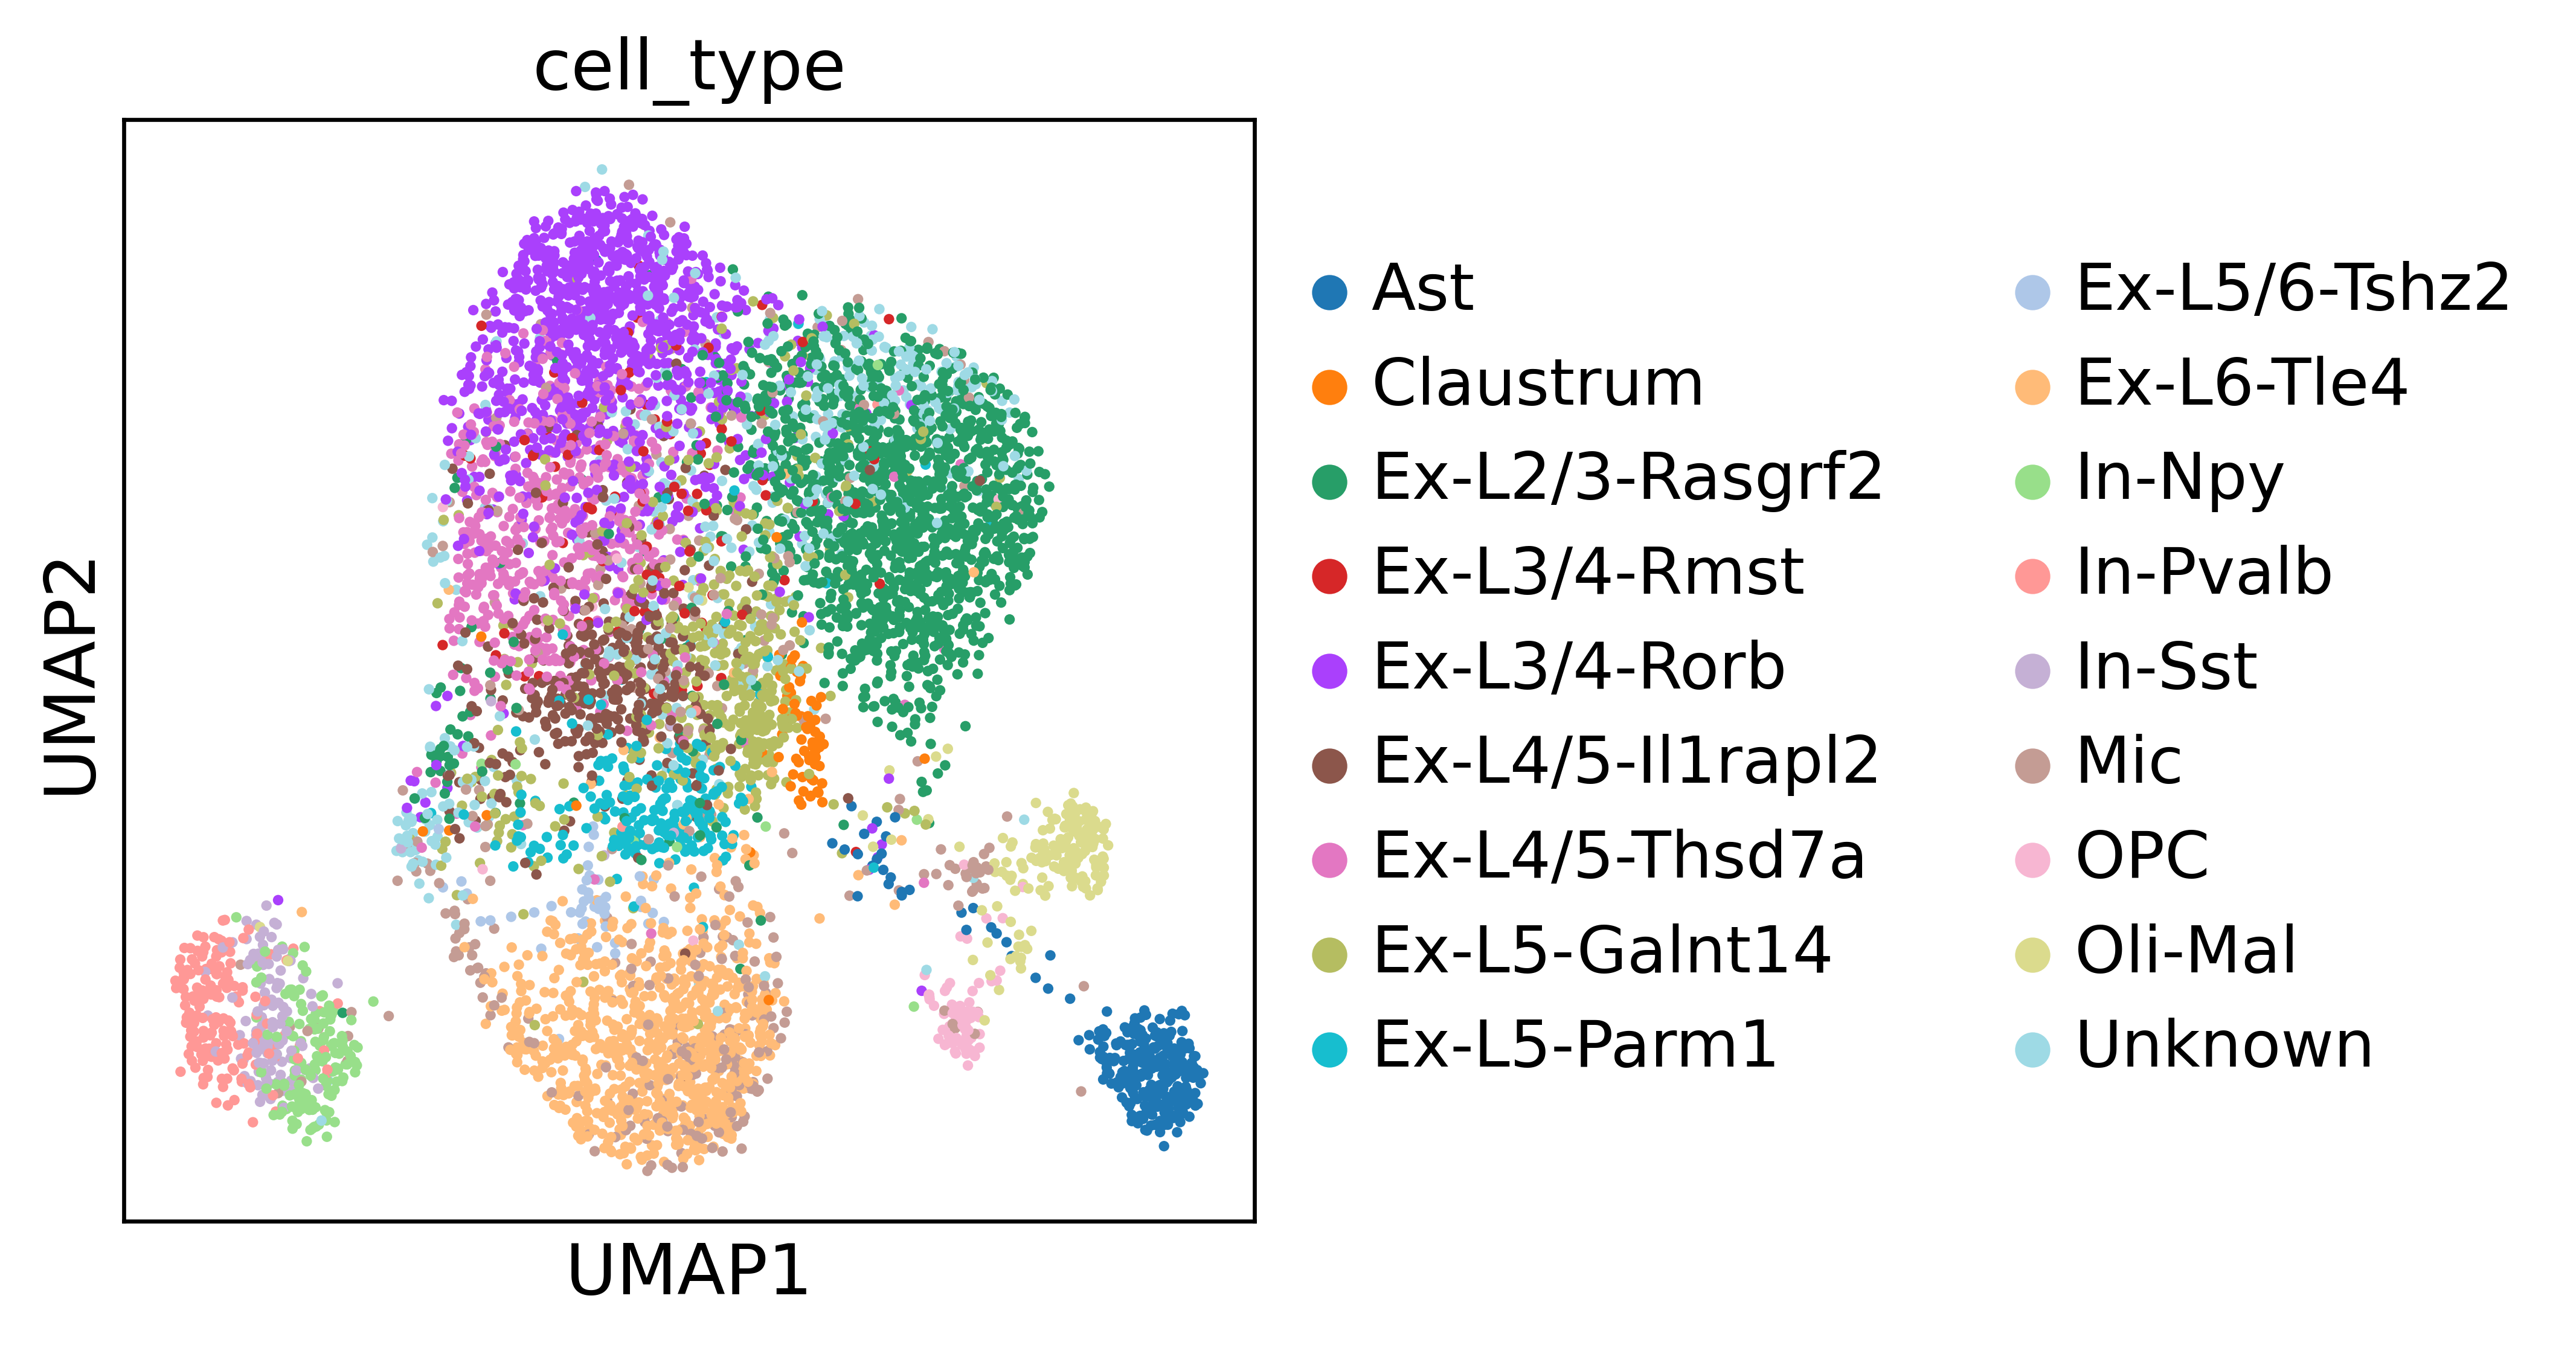

In [24]:
sc.pl.umap(rna_train_ann, color='cell_type') 

In [ ]:
rna_trans.shape

In [ ]:
import benplot

In [ ]:
benplot.plot_lowdim_rep(rna_trans, rna_val_labels)

In [ ]:
rna_val = data['rna_test']
reducer = umap.UMAP(densmap=True, min_dist=0.001) 
rna_true_trans = reducer.fit_transform(rna_val)

In [ ]:
benplot.plot_lowdim_rep(rna_true_trans, rna_val_labels)

In [ ]:
from sklearn.decomposition import PCA

rna_val = data['rna_test']
reducer = PCA(n_components=2) 
rna_true_trans = reducer.fit_transform(rna_val)
benplot.plot_lowdim_rep(rna_true_trans, rna_val_labels)

In [ ]:
reducer = PCA(n_components=2) 
rna_pred_trans = reducer.fit_transform(rna_val_pred.detach().cpu().numpy())
benplot.plot_lowdim_rep(rna_pred_trans, rna_val_labels)

In [ ]:
rna_val = torch.Tensor(rna_val).to('cuda:0')
atac_val_pred = ckpt_model(rna_val,data_type='rna')

In [ ]:
atac_val_pred

In [ ]:
atac_val_pred

In [ ]:
type(atac_val)

In [ ]:
from sklearn.metrics import roc_auc_score
import pandas as pd

aurocs = []
for i in range(atac_val.shape[1]):
    auroc = roc_auc_score(atac_val[:, i].detach().cpu().numpy(), atac_val_pred[:, i].detach().cpu().numpy())
    aurocs.append(auroc)

atac_rocs = pd.DataFrame()
atac_rocs['auroc'] = aurocs

In [ ]:
atac_rocs.hist()

In [ ]:
atac_rocs.mean()